In [1]:
# In order to force the reload of modules
# %load_ext autoreload
# %autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

from ml.rl.core import *

import abc
from collections import *
from dataclasses import *
import enum
import gym
import heapq
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, trange
# from tqdm import tnrange, tqdm_notebook
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
"""
A way to log what happens inside an environment
"""


class RecordingEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observations = []
        self.actions = []

    def reset(self, **kwargs):
        while len(self.observations) > len(self.actions):
            self.observations.pop()
        observation = self.env.reset(**kwargs)
        self.observations.append(observation)
        return observation
        
    def step(self, action):
        self.actions.append(action)
        observation, reward, done, info = self.env.step(action)
        if not done:
            self.observations.append(observation)
        return observation, reward, done, info


"""
Trying the agent on cartpole
"""


def try_agent_on(env, agent: Agent, show=True) -> float:
    total_reward = 0.0
    obs = env.reset()
    if show:
        env.render()
    done = False
    while not done:
        action = agent.get_action(env, obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if show:
            env.render()
    if show:
        print("Total reward {0:.2f}".format(total_reward))
    return total_reward


def try_agent(agent: Agent, show=True):
    with gym.make("CartPole-v0") as env:
        return try_agent_on(env, agent, show=show)

    
def evaluate_performance(agent: Agent, episodes: int = 100):
    total_reward = 0.0
    for _ in range(episodes):
        total_reward += try_agent(agent, show=False)
    print("Average performance:", total_reward / episodes)
    

"""
Random agent
"""


class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()

    
evaluate_performance(RandomAgent())


"""
Logging the actions (will be useful for imitation learning)
"""


with gym.make("CartPole-v0") as env:
    env = RecordingEnv(env)
    for _ in range(10):
        try_agent_on(env, RandomAgent(), show=False)
    print(len(env.observations))
    print(len(env.actions))
    
    print(env.observations[:5])
    print(env.actions[:5])

Average performance: 22.85
223
223
[array([-0.03054924, -0.02844973,  0.0239205 ,  0.02280656]), array([-0.03111823,  0.16632115,  0.02437663, -0.26223423]), array([-0.02779181, -0.02914012,  0.01913194,  0.0380366 ]), array([-0.02837461, -0.22453113,  0.01989267,  0.33669392]), array([-0.03286523, -0.02969783,  0.02662655,  0.05034985])]
[1, 0, 0, 1, 0]


In [9]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


# try_agent(BrutalAgent())
evaluate_performance(RandomAgent())

Average performance: 22.23


PID(kp=1.0, kd=0.1, ki=0.0)
Average performance: 200.0


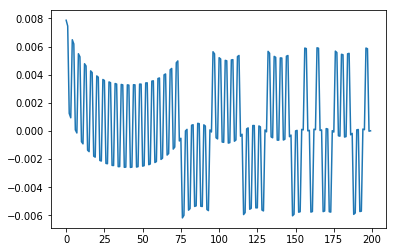

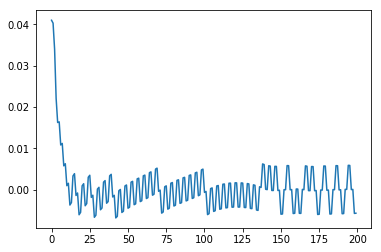


PID(kp=1.0, kd=0.03, ki=0.0)
Average performance: 200.0


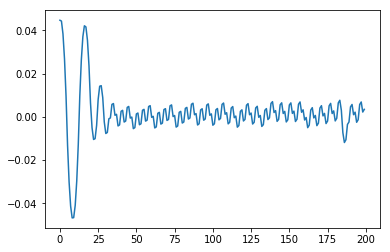

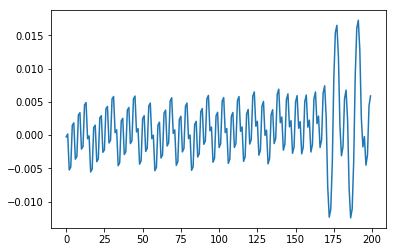


PID(kp=1.0, kd=0.01, ki=0.0)
Average performance: 90.01


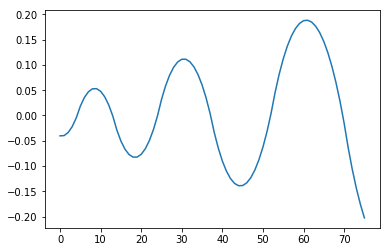

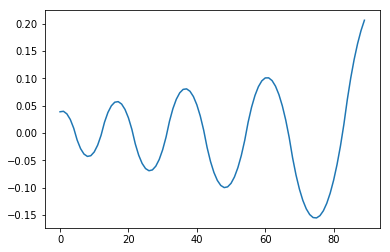


PID(kp=1.0, kd=3.0, ki=0.0)
Average performance: 196.04


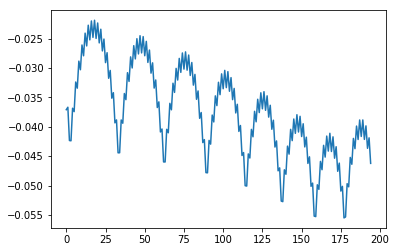

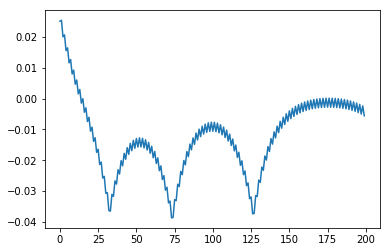


PID(kp=1.0, kd=0.0, ki=0.0)
Average performance: 42.06


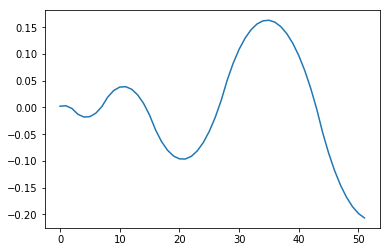

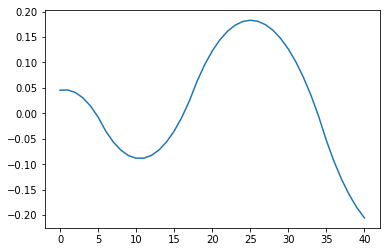

In [47]:
"""
Application of PID circuit (limited to linear systems):

The idea is to have closed loop circuit (compared the the open circuit with no feedback) and to minimize
an erreur between what is desired G (goal), and what is obtained R (result).

We have three quantities:
* Potential(E) = E = criterion on (G - R)
* Integral(E) = accumulate the error over time
* Derivative(E) = derivative of the error over time

In linear system, you have:
* R = A (amplification) * E (error)
* E = G - R
=> R = A * (G - R)
=> R * (1 + A) = G * A
=> R / G = A / (1 + A)

We want R = G, so we want A to be big, but there will always be a static error.
So we could wich to increase A enormously, but then the curve will overshoot at first, by a large margin.
=> The goal is to have A vary with time (any static A will fail)

We look for 3 coeficients Kp, Ki and Kd, such that:
A = Kp * Potential(E) + Ki * Integral(E) + Kd * Derivative(d)

Actually, we also search a fourth constant K, such that
A = Kp * Potential(E) + Ki * Integral(E) + Kd * Derivative(d) + K

Another way to see this is that we modify the error E to make sure that the circuit will act on the output correctly.

The BIG DIFFICULTY here, is that we do not have a perfect control of the input (just the LEFT or RIGHT) and that
we have discretized inputs.

The usual success measure for such system is to measure the response time: the time at which the system enter
in range 95% to 105% to the target (we could measure here, the response time at which it goes below 1°)
"""


class PIDAgent(abc.ABC):
    def __init__(self, kp=1., ki = 0.1, kd=0.03):
        self.int_error = 0
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        error = theta
        self.int_error += error
        amplification = self.kp * error + self.ki * self.int_error + self.kd * theta_dot
        if amplification > 0:
            return 1
        else:
            return 0
    
    def __repr__(self):
        return "PID(kp=" + str(self.kp) + ", kd=" + str(self.kd) + ", ki=" + str(self.ki) + ")"


"""
Try different parameterization of the PID
- show the evolation of theta as time goes by (and see that it goes into a )
"""
    

agents = [PIDAgent(kp=1., ki = 0.0, kd=0.1),
          PIDAgent(kp=1., ki = 0.0, kd=0.03),
          PIDAgent(kp=1., ki = 0.0, kd=0.01),
          PIDAgent(kp=1., ki = 0.0, kd=3.),
          PIDAgent(kp=1., ki = 0.0, kd=0.)]

for i, agent in enumerate(agents):
    if i > 0:
        print()
    print(agent)
    evaluate_performance(agent)
    with gym.make("CartPole-v0") as env:
        for _ in range(2):
            env = RecordingEnv(env)
            try_agent_on(env, agent, show=False)
            plt.plot([theta for x, x_dot, theta, theta_dot in env.observations])
            plt.show()

In [48]:
"""
Demonstration
"""


try_agent(PIDAgent(kp=1., ki = 0.0, kd=0.1))

Total reward 200.00


200.0

In [25]:
"""
SEARCHING:
- go several actions deep in advance and try to minimize the theta
- requires a MODEL of the environment to do PREDICTIONS

GENETIC ALGORITHM APPROACH?
- must have a genome if fixed length + a fitness function
- maybe more a RANDOMIZED BEAM SEARCH?
- requires a MODEL of the environment to do PREDICTIONS
"""


# TODO - try different search mechanisms (iterative deepening? A-star?)
pass

In [32]:
"""
IMITATION LEARNING + DAGGER:
- collect samples from a "teacher" and use it to train a model in a supervised manner
- the problem is that the training sample probability distribution will not match the policy
  distribution (https://www.youtube.com/watch?v=xZKj7Z1CwHc) at the first error of the trained model
- the solution is DAGGER: iterate through the loop:
   1. train the policy on the data set
   2. capture the samples from the polcy, but not the action
   3. use the "teacher" to label the samples (give the right action)
   4. enrich the data-set using these new training samples
=> the training distributions should converge to the policy distribution and make it robust
"""


"""
Implementation of a policy P(action | state) to learn via a Neural Net
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(4, 20), nn.ReLU(), nn.Linear(20, 2))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, state, with_softmax=True):
        ys = self.fc(state)
        if with_softmax:
            ys = self.softmax(ys)
        return ys

    
class PolicyAgent(Agent):
    def __init__(self, policy_net: nn.Module):
        self.policy_net = policy_net
    
    def get_action(self, env, state):
        state = torch.FloatTensor(state)
        action_probs = self.policy_net(state, with_softmax=True)
        distribution = torch.distributions.categorical.Categorical(action_probs)
        return distribution.sample().item()


"""
Getting data from the trainer
"""


def collection_samples_from_agent(agent: Agent, iteration_nb: int) -> Tuple['observations', 'actions']:
    with gym.make("CartPole-v0") as env:
        env = RecordingEnv(env)
        for _ in range(iteration_nb):
            try_agent_on(env, agent, show=False)
        return env.observations, env.actions

    
def train_on_expert_data(policy: PolicyNet, observations: List[np.ndarray], actions: List[int],
                         epoch_nb: int, learning_rate: float) -> List['loss']:
    policy.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    
    xs = np.stack(observations)
    xs = torch.FloatTensor(xs)
    ys = torch.LongTensor(actions)
    data_set = data.TensorDataset(xs, ys)
    data_loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
    
    losses = []
    for _ in prange(epoch_nb):
        total_loss = 0.
        for observation, expected in data_loader:
            got = policy(observation, with_softmax=False)
            optimizer.zero_grad()
            loss = criterion(got, expected)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
    return losses


def imitation_learning(policy: nn.Module, expert: Agent):
    print("Collecting samples from expert...")
    observations, actions = collection_samples_from_agent(expert, iteration_nb=10)
    print("Training the policy on {0} collected samples".format(len(observations)))
    losses = train_on_expert_data(policy, observations, actions, epoch_nb=50, learning_rate=1e-2)
    plt.plot(losses)
    plt.show()


"""
DAGGER
"""


def label_samples(expert: Agent, observations: List[np.ndarray]):
    env = None # Hack
    return [expert.get_action(env, o) for o in observations]


def dagger(policy: nn.Module, expert: Agent, iteration_nb: int):
    print("Collecting samples from expert...")
    observations, actions = collection_samples_from_agent(expert, iteration_nb=10)
    print("Training the policy on {0} collected samples".format(len(observations)))
    losses = train_on_expert_data(policy, observations, actions, epoch_nb=50, learning_rate=1e-2)
    for _ in range(iteration_nb):
        print("Collecting samples from policy...")
        new_observations, _ = collection_samples_from_agent(PolicyAgent(policy), iteration_nb=10)
        observations.extend(new_observations)
        actions.extend(label_samples(expert, new_observations))
        print("Training the policy on {0} collected samples".format(len(observations)))
        losses.extend(train_on_expert_data(policy, observations, actions, epoch_nb=50, learning_rate=1e-2))
    plt.plot(losses)
    plt.show()

Training the policy on 2000 collected samples
49/50 (98.00%) - 35.37 it/s


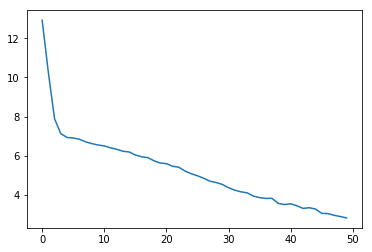

Average performance: 200.0


In [49]:
"""
Trying simple imitation learning
"""
    
policy = PolicyNet()
imitation_learning(policy, expert=PIDAgent(kp=1., ki = 0.0, kd=0.1))
evaluate_performance(PolicyAgent(policy))

Training the policy on 2000 collected samples
48/50 (96.00%) - 39.41 it/s
Training the policy on 4000 collected samples
49/50 (98.00%) - 20.21 it/s
Training the policy on 6000 collected samples
49/50 (98.00%) - 12.00 it/s
Training the policy on 8000 collected samples
50/50 (100.00%) - 9.12 it/s
Training the policy on 10000 collected samples
50/50 (100.00%) - 7.75 it/s
Training the policy on 12000 collected samples
50/50 (100.00%) - 6.55 it/s


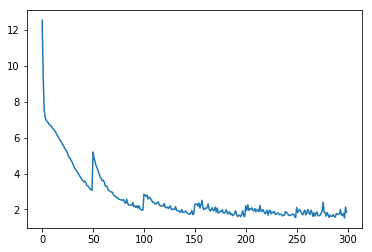

Average performance: 200.0


In [50]:
"""
Trying simple imitation learning + Dagger
"""
    
policy = PolicyNet()
dagger(policy, expert=PIDAgent(kp=1., ki = 0.0, kd=0.1), iteration_nb=5)
evaluate_performance(PolicyAgent(policy))

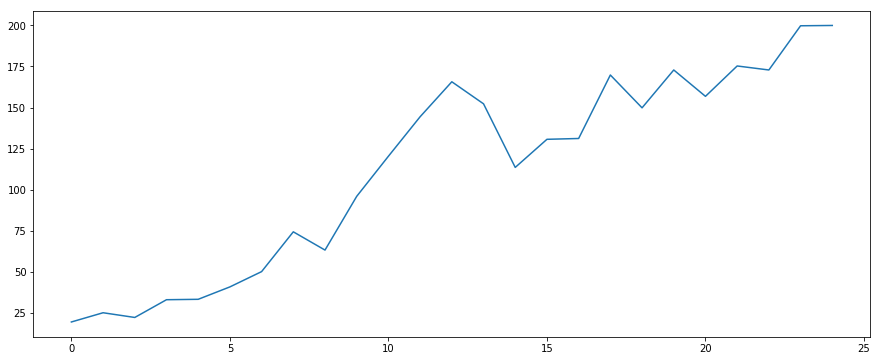

In [32]:
"""
CROSS ENTROPY METHOD:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)

Looks like a kind of GENETIC ALGORITHM / RANDOMIZED BEAM SEARCH kind of stuff, in that it takes
the best element out of the main experients, but:
- it does not do it by SEARCH
- it does not keep the best episode of all times
"""


"""
Implementation of a policy P(action | state) to learn via a Neural Net
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(4, 20), nn.ReLU(), nn.Linear(20, 2))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, state, with_softmax=True):
        ys = self.fc(state)
        if with_softmax:
            ys = self.softmax(ys)
        return ys

    
class PolicyAgent(Agent):
    def __init__(self, policy_net: nn.Module):
        self.policy_net = policy_net
    
    def get_action(self, env, state):
        state = torch.FloatTensor(state)
        action_probs = self.policy_net(state, with_softmax=True)
        distribution = torch.distributions.categorical.Categorical(action_probs)
        return distribution.sample().item()
    
    
"""
Cross Entropy learning
"""


@dataclass(frozen=False)
class EpisodeOutcome:
    states: List[np.ndarray] = field(default_factory=list)
    actions: List[int] = field(default_factory=list)
    score: float = 0.


def play_episode(env, policy: nn.Module) -> EpisodeOutcome:
    outcome = EpisodeOutcome()
    policy = PolicyAgent(policy)
    state = env.reset()
    done = False
    while not done:
        action = policy.get_action(env, state)
        outcome.states.append(state)
        outcome.actions.append(action)
        state, reward, done, _ = env.step(action)
        outcome.score += reward
    return outcome


def to_data_set(episodes: List[EpisodeOutcome]) -> data.TensorDataset:
    xs, ys = [], []
    for episode in episodes:
        xs.extend(episode.states)
        ys.extend(episode.actions)
    return data.TensorDataset(torch.FloatTensor(xs), torch.LongTensor(ys))


def improve_policy(policy: nn.Module, episodes: List[EpisodeOutcome], iteration_nb: int, learning_rate: float):
    policy.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loader = data.DataLoader(to_data_set(episodes), batch_size=100, shuffle=True)
    for _ in range(iteration_nb):
        for states, actions in loader:
            optimizer.zero_grad()
            got = policy(states, with_softmax=False)
            loss = criterion(got, actions)
            loss.backward()
            optimizer.step()
            

def train_cross_entropy(env, policy: nn.Module,
                        iteration_count: int = 100,
                        batch_size: int = 1000,
                        batch_threshold: float = 0.7,
                        batch_iterations: int = 100,
                        learning_rate: float = 1e-1,
                        learning_rate_decay: float = 1.0) -> List[float]:
    mean_scores = []
    for _ in prange(iteration_count):
        episodes = [play_episode(env, policy) for _ in range(batch_size)]
        mean_score = np.mean([e.score for e in episodes])
        mean_scores.append(mean_score)
        if mean_score >= 200:
            break
        
        episodes.sort(key=lambda e: e.score)
        episodes = episodes[int(batch_threshold * batch_size):]
        improve_policy(policy, episodes, batch_iterations, learning_rate)
        learning_rate *= learning_rate_decay
    return mean_scores


"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    policy_net = PolicyNet()
    scores = train_cross_entropy(env, policy_net,
                                 iteration_count=100, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1, learning_rate_decay=1.0)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

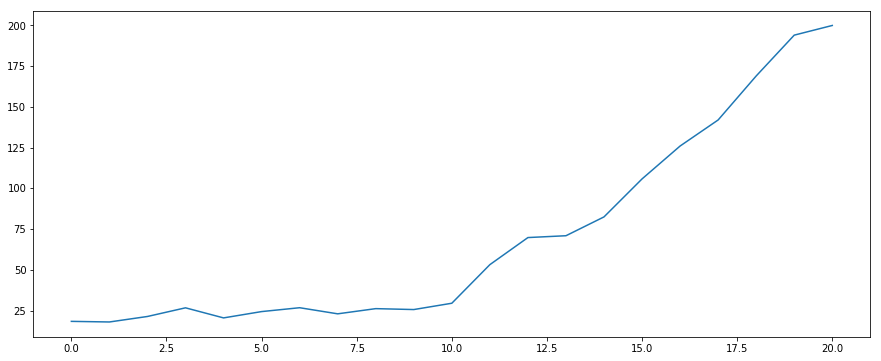

In [34]:
"""
A simpler neural net (the PID manages with just 3 variables)
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 2)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, state, with_softmax=True):
        ys = self.fc(state)
        if with_softmax:
            ys = self.softmax(ys)
        return ys

    
"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    policy_net = PolicyNet()
    scores = train_cross_entropy(env, policy_net,
                                 iteration_count=150, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1, learning_rate_decay=1.0)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

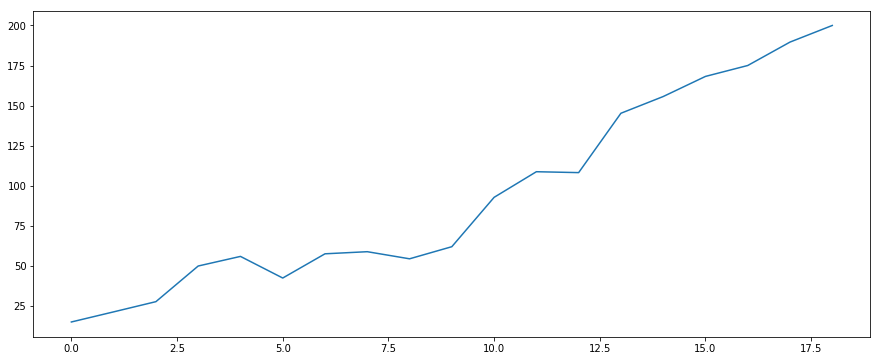

In [35]:
class PolynomialRegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        feature_size = self._transform(torch.zeros(4)).shape[0]
        self.fc = nn.Linear(feature_size, 2)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax=False):
        if len(observations.shape) == 2:
            xs = torch.stack([self._transform(observation) for observation in observations])
        else:
            xs = self._transform(observations)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys)
        return ys
    
    def _transform(self, observation):
        xs = list(observation)
        k = len(observation)
        for i in range(k-1):
            for j in range(i+1, k):
                xs.append(observation[i] * observation[j])
        return torch.FloatTensor(xs)
    

"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    polynomial_net = PolynomialRegressionNet()
    scores = train_cross_entropy(env, polynomial_net,
                                 iteration_count=150, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1, learning_rate_decay=1.0)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

Solved!1000 (50.80%) - 9.25 it/sss


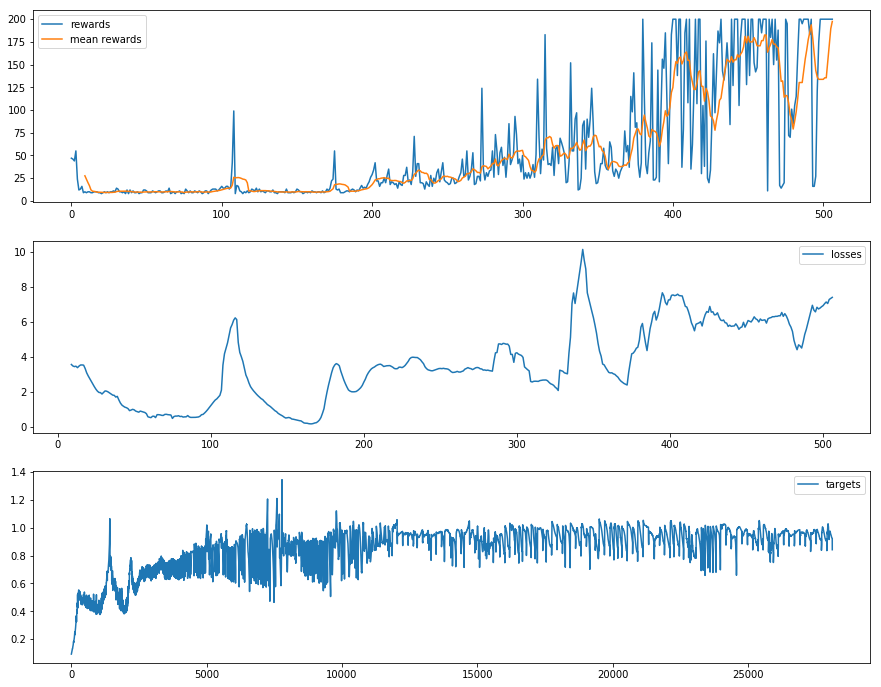

In [36]:
"""
With Deep SARSA Learning
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))

    def forward(self, xs):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        return ys

    
class PolicyAgent:
    def __init__(self, sarsa_net):
        self.sarsa_net = sarsa_net
        
    def get_action(self, env, state):
        action_values = self.sarsa_net(state)
        _, i = torch.max(action_values, dim=-1)
        return i.item()

    
def epsilon_greedy_action(policy: nn.Module, state, epsilon) -> Tuple[int, float]:
    action_values = policy(state)
    if np.random.rand(1) < epsilon:
        action = env.action_space.sample()
        return action, action_values[action]
    else:
        action_value, action = torch.max(action_values, dim=-1)
        return action.item(), action_value
    

def train_sarsa_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        action, action_value = epsilon_greedy_action(policy, state, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action, next_action_value = epsilon_greedy_action(policy, next_state, epsilon)
            
            # Apply the bellman update
            optimizer.zero_grad()
            if not done:
                target = reward + discount * next_action_value.detach()
            else:
                target = torch.tensor(reward)
            loss = criterion(action_value, target)
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
            
            # Moving to next state
            episode_reward += reward
            state = next_state
            action = next_action
            action_value = next_action_value
            targets.append(target)

        # Criteria of success
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()

    
"""
Training
"""

sarsa_net = PolicyNet()
with gym.make("CartPole-v0") as env:
    train_sarsa_learning(
        env, policy=sarsa_net, episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)

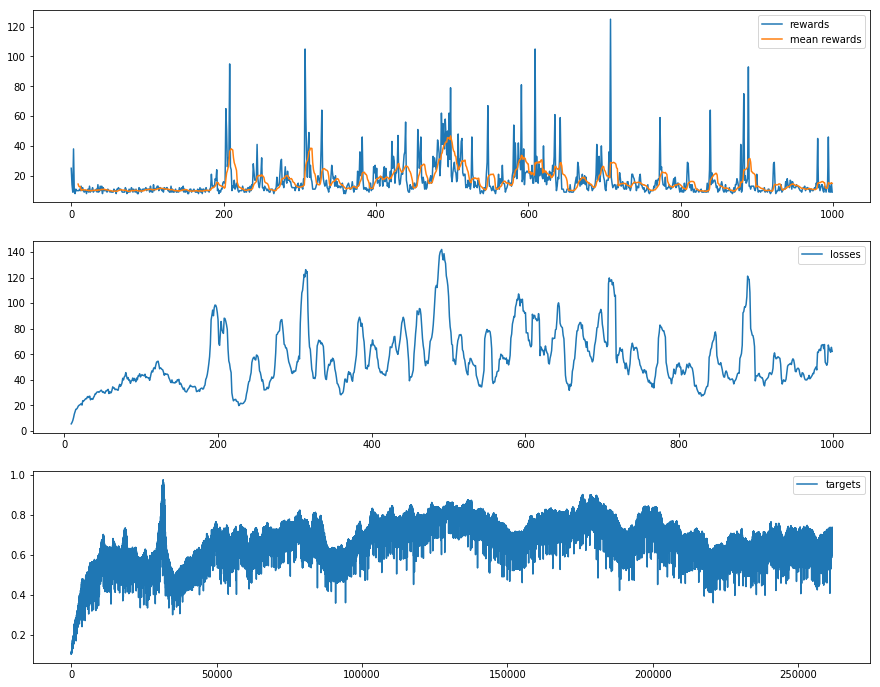

In [6]:
"""
With Deep Q Learning
"""


# TODO - try double learning


def train_q_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    replay_buffer = deque(maxlen=1000)
    
    count_success = 0
    for _ in prange(episodes):        
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            action, action_value = epsilon_greedy_action(policy, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            # Storing into the replay buffer
            replay_buffer.append((state, action, next_state, done))
            
            # Extract a mini batch from the replay buffer
            if len(replay_buffer) >= 100:
                losses = []
                for s, a, s2, d in random.choices(replay_buffer, k=16):
                    next_action_values = policy(s2)
                    if not d:
                        next_action_value, _ = torch.max(next_action_values, dim=-1)
                        target = reward + discount * next_action_value.detach()
                    else:
                        target = torch.tensor(reward)
                    losses.append(criterion(action_value, target))
                    targets.append(target)
            
                # Apply the bellman update
                optimizer.zero_grad()
                loss = sum(losses)
                loss.backward()
                optimizer.step()
                episode_loss += loss
            
            # Moving to next state
            episode_reward += reward
            state = next_state
        
        # Criteria of success
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()


"""
Training
"""


with gym.make("CartPole-v0") as env:
    train_q_learning(
        env, policy=PolicyNet(), episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)

Solved!/2000 (69.75%) - 12.65 it/s


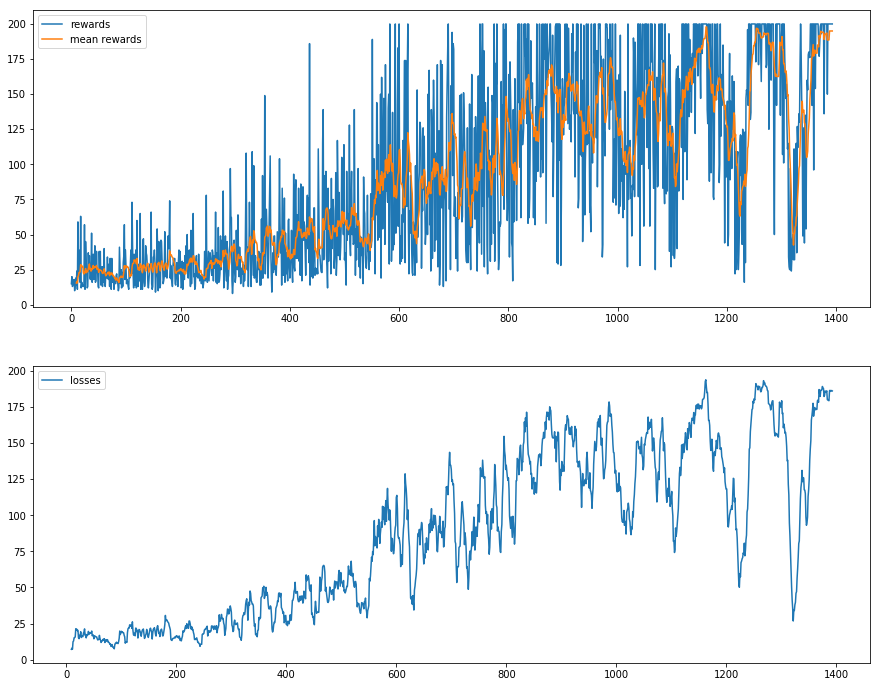

In [38]:
"""
REINFORCE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            ys = self.softmax(ys)
        return ys


def train_reinforce(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        while not done:
            probs = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        policy_losses = []
        for state, action, reward in minibatch:
            probs = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            policy_losses.append(- log_prob * reward) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)

Solved!/2000 (53.75%) - 9.96 it/ss


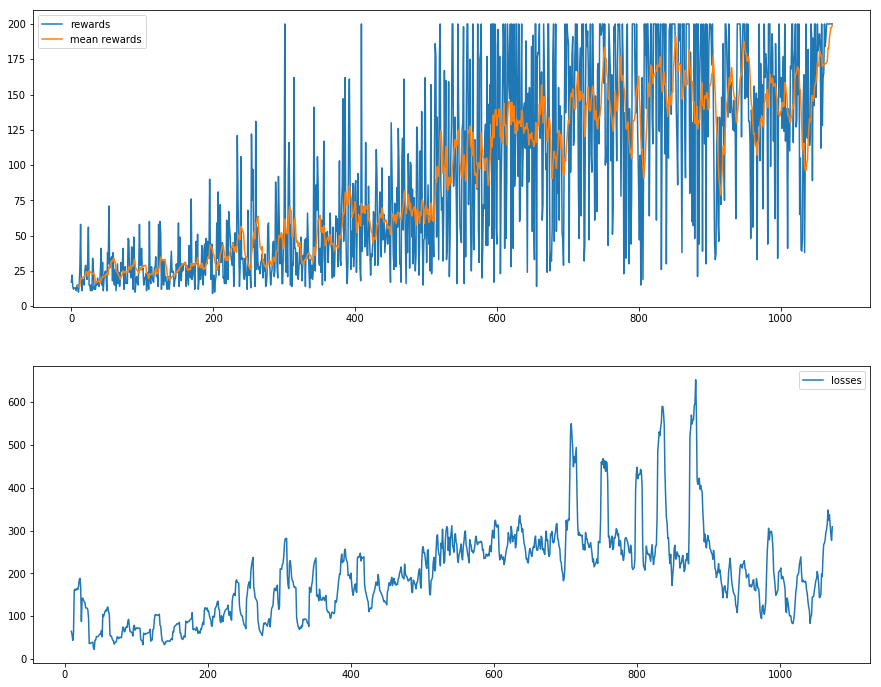

In [36]:
"""
REINFORCE + BASELINE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 3))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys[:2]), ys[2:]
        return ys[:2], ys[2:]


def train_reinforce_baseline(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        episode_reward = 0.
        while not done:
            probs, _ = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        value_losses = []
        policy_losses = []
        for state, action, reward in minibatch:
            probs, value = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            value_losses.append(torch.pow(reward - value, 2))
            policy_losses.append(- log_prob * (reward - value.item())) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses) + sum(value_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce_baseline(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)

1991/2000 (99.55%) - 143.02 it/s


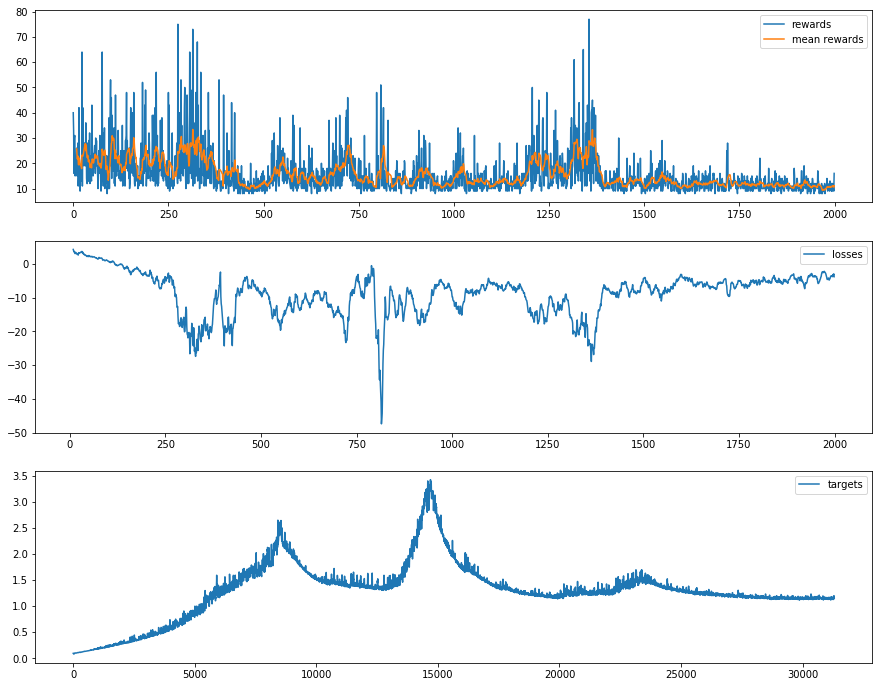

In [52]:
"""
ACTOR-CRITIC method:
- policy gradient method inspired by TD learning
- same as REINFORCE with Baseline, but we bootstrap the value function
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(4, 100), nn.ReLU(), nn.Linear(100, 3))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys[:2]), ys[2:]
        return ys[:2], ys[2:]


def train_actor_critic(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            
            # Select an action
            probs, value = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Get the target value
            _, next_value = policy(next_state, with_softmax=False)
            target_value = reward + discount * next_value.detach()
            targets.append(target_value.item())
            
            # Compute the value loss and policy loss & update neural net
            optimizer.zero_grad()
            value_loss = torch.pow(value - target_value, 2)
            policy_loss = - torch.log(probs[action]) * (reward - value.item())
            loss = value_loss + policy_loss
            loss.backward()
            optimizer.step()
            
            # Update the policy probabilities
            episode_loss += loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_actor_critic(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)